In [102]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


# Bron-Kerbosh algorithm

The Bron–Kerbosch algorithm is a classic algorithm in computer science used for finding all maximal cliques in an undirected graph. A clique is a subset of vertices such that every two distinct vertices are adjacent. A maximal clique is a clique that cannot be extended by including one more adjacent vertex.

The algorithm operates using a recursive backtracking approach and is known for its efficiency in practice, despite having an exponential worst-case time complexity. It is widely used in various applications, including social network analysis, bioinformatics, and network topology.

The Bron–Kerbosch algorithm can be implemented in different variations, including pivoting and degeneracy ordering, to improve its performance on specific types of graphs. We want to focus on **why pivoting works?**

The idea of pivoting is to not explore the nodes that are connected to a node that 
. This reduces the number of recursive calls and improves the efficiency of the algorithm.


**IDEA**


We choose a pivot p. Now any clique must contain p or a non-neighbour of p. This is true since if a clique contains doesn't contain a non-neighbour ( only contains neighbours ) then p can be added. 

Then we can look reduce the look from all the posibilities to `candidates - neighbours[p]`.

Ideally we would choose a p that makes sense, like one that has a high degree.

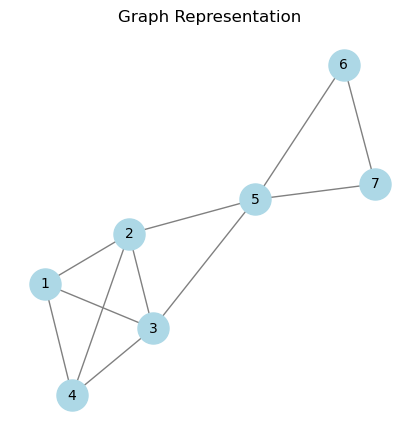

In [103]:

# code taken from https://github.com/cornchz/Bron-Kerbosch/tree/master

# Adjacency list (starting index 1)
NEIGHBORS = [
    [],  # Ignoring index 0
    [2, 3, 4],
    [1, 3, 4, 5],
    [1, 2, 4, 5],
    [1, 2, 3],
    [2, 3, 6, 7],
    [5, 7],
    [5, 6]
]
NODES = set(range(1, len(NEIGHBORS)))

# Create a graph
G = nx.Graph()

# Add edges based on adjacency list
for node, neighbors in enumerate(NEIGHBORS):
    if node == 0:  # Skip index 0
        continue
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

# Draw the graph
plt.figure(figsize=(4, 4))
pos = nx.spring_layout(G, seed = 42)  # Layout for nodes
nx.draw(
    G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500, font_size=10
)
plt.title("Graph Representation")
plt.show()

In [104]:
MIN_SIZE = 3

class Reporter(object):
    def __init__(self, name, verbose):
        self.name = name
        self.cnt = 0
        self.cliques = []
        self.verbose = verbose
 
    def inc_count(self):
        self.cnt += 1
 
    def record(self, clique):
        self.cliques.append(clique)
 
    def print_report(self):
        print (self.name)
        print ('%d recursive calls' % self.cnt)
        for i, clique in enumerate(self.cliques):
            print ('%d: %s' % (i, clique))
        print()


def pick_random(s):
    if s:
        elem = s.pop()
        s.add(elem)
        return elem


def bronker_bosch1(clique, candidates, excluded, reporter, depth = 0):
    '''Naive Bron–Kerbosch algorithm'''
    if reporter.verbose:
        print(f'{'---'*depth}clique: {clique}, candidates: {candidates}, excluded: {excluded}')
    reporter.inc_count()
    if not candidates and not excluded:
        if len(clique) >= MIN_SIZE:
            reporter.record(clique)
        return
 
    for v in list(candidates):
        new_candidates = candidates.intersection(NEIGHBORS[v])
        new_excluded = excluded.intersection(NEIGHBORS[v])
        bronker_bosch1(clique + [v], new_candidates, new_excluded, reporter, depth+1)
        candidates.remove(v)
        excluded.add(v)



def bronker_bosch2(clique, candidates, excluded, reporter, depth = 0):
    '''Bron–Kerbosch algorithm with pivot'''
    if reporter.verbose:
        print(f'{'---'*depth}clique: {clique}, candidates: {candidates}, excluded: {excluded}')
    reporter.inc_count()
    if not candidates and not excluded:
        if len(clique) >= MIN_SIZE:
            reporter.record(clique)
        return
 
    pivot = pick_random(candidates) or pick_random(excluded)
    for v in list(candidates.difference(NEIGHBORS[pivot])):
        new_candidates = candidates.intersection(NEIGHBORS[v])
        new_excluded = excluded.intersection(NEIGHBORS[v])
        bronker_bosch2(clique + [v], new_candidates, new_excluded, reporter, depth+1)
        candidates.remove(v)
        excluded.add(v)


funcs = [bronker_bosch1,
		bronker_bosch2]

for func in funcs:
	report = Reporter('## %s' % func.__doc__, verbose = True)
	func([], set(NODES), set(), report)
	report.print_report()

clique: [], candidates: {1, 2, 3, 4, 5, 6, 7}, excluded: set()
---clique: [1], candidates: {2, 3, 4}, excluded: set()
------clique: [1, 2], candidates: {3, 4}, excluded: set()
---------clique: [1, 2, 3], candidates: {4}, excluded: set()
------------clique: [1, 2, 3, 4], candidates: set(), excluded: set()
---------clique: [1, 2, 4], candidates: set(), excluded: {3}
------clique: [1, 3], candidates: {4}, excluded: {2}
---------clique: [1, 3, 4], candidates: set(), excluded: {2}
------clique: [1, 4], candidates: set(), excluded: {2, 3}
---clique: [2], candidates: {3, 4, 5}, excluded: {1}
------clique: [2, 3], candidates: {4, 5}, excluded: {1}
---------clique: [2, 3, 4], candidates: set(), excluded: {1}
---------clique: [2, 3, 5], candidates: set(), excluded: set()
------clique: [2, 4], candidates: set(), excluded: {1, 3}
------clique: [2, 5], candidates: set(), excluded: {3}
---clique: [3], candidates: {4, 5}, excluded: {1, 2}
------clique: [3, 4], candidates: set(), excluded: {1, 2}
----

## Using a random Graph to show the worst case scenario

When the Graph is a fully connected graph this algorithm has to take 2^n steps, which is really bad. Using pivot we reduce the number of steps to n. 

This shows that pivot really shines when there is a big amount of cliques. When the amount of cliques is small the amount of steps saved is not that big

In [105]:
from random import random
from itertools import product, combinations

def random_graph(n, p, *, directed=False):
    nodes = range(n)
    adj_list = [[] for i in nodes]
    possible_edges = product(nodes, repeat=2) if directed else combinations(nodes, 2)
    for u, v in possible_edges:
        if random() < p:
            adj_list[u].append(v)
            if not directed:
                adj_list[v].append(u)
    return adj_list


n = 100
MIN_SIZE = n
NEIGHBORS = [[]]+random_graph(n, 0.08)
for i in range(len(NEIGHBORS)):
     NEIGHBORS[i] = np.array(NEIGHBORS[i]) +1
# print(NEIGHBORS)
NODES = set(range(1,n+1))
G = nx.Graph()
for node, neighbors in enumerate(NEIGHBORS):
    if node == 0:  # Skip index 0
        continue
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

for func in funcs:
    report = Reporter('## %s' % func.__doc__, verbose = False)
    func([], set(NODES), set(), report)
    report.print_report()

## Naive Bron–Kerbosch algorithm
560 recursive calls

## Bron–Kerbosch algorithm with pivot
535 recursive calls



In [106]:
n = 100
MIN_SIZE = n
NEIGHBORS = [[]]+random_graph(n, 0.5)
for i in range(len(NEIGHBORS)):
     NEIGHBORS[i] = np.array(NEIGHBORS[i]) +1
# print(NEIGHBORS)
NODES = set(range(1,n+1))
G = nx.Graph()
for node, neighbors in enumerate(NEIGHBORS):
    if node == 0:  # Skip index 0
        continue
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

for func in funcs:
	report = Reporter('## %s' % func.__doc__, verbose = False)
	func([], set(NODES), set(), report)
	report.print_report()

## Naive Bron–Kerbosch algorithm
166641 recursive calls

## Bron–Kerbosch algorithm with pivot
78033 recursive calls



In [107]:
n = 15
MIN_SIZE = n+1
NEIGHBORS = [[]]+random_graph(n, 1)
for i in range(len(NEIGHBORS)):
     NEIGHBORS[i] = np.array(NEIGHBORS[i]) +1
# print(NEIGHBORS)
NODES = set(range(1,n+1))
G = nx.Graph()
for node, neighbors in enumerate(NEIGHBORS):
    if node == 0:  # Skip index 0
        continue
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

for func in funcs:
	report = Reporter('## %s' % func.__doc__, verbose = False)
	func([], set(NODES), set(), report)
	report.print_report()

## Naive Bron–Kerbosch algorithm
32768 recursive calls

## Bron–Kerbosch algorithm with pivot
16 recursive calls



# Louvain Algorithm

Is an iterative algorithm that aim to optimize the modularity of the network, which is a measure of the density of links inside communities compared to links between communities.

## Steps of the Louvain Algorithm

1. **Initialization**: Each node is initially assigned to its own community.
2. **Modularity Optimization**: For each node, the algorithm evaluates the gain in modularity by moving the node to the community of each of its neighbors. The node is then moved to the community that results in the highest gain in modularity.
3. **Community Aggregation**: Once no further improvement can be made, each community is treated as a single node, and the process is repeated.

## Importance of Node Order

The order in which nodes are processed can significantly impact the results of the Louvain algorithm. Different node orders can lead to different community structures, beacause the algorithm is greedy and chooses the best node in a first to come basis. We explore the meaning of using one 

In [ ]:
from sknetwork.data import karate_club
from sknetwork.clustering import Louvain, get_modularity
from sknetwork.visualization import visualize_graph
from IPython.display import SVG, display_html
from sknetwork.ranking import PageRank, Katz
from sknetwork.data import from_edge_list
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

Modularity: 0.41880341880341876


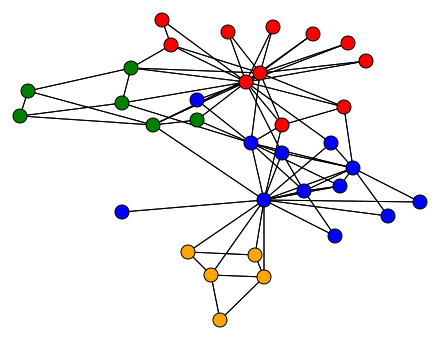

In [134]:
graph = karate_club(metadata=True)
adjacency = graph.adjacency
names = None
position = graph.position
# clustering
louvain = Louvain()
labels = louvain.fit_predict(adjacency)
image = visualize_graph(adjacency, position, names=names, labels=labels)
print(f'Modularity: {get_modularity(adjacency, labels)}')
SVG(image)

In [135]:
# Ordering py pagerank ASC
def invert_permutation(p):
    """Return an array s with which np.array_equal(arr[p][s], arr) is True.
    The array_like argument p must be some permutation of 0, 1, ..., len(p)-1.
    """
    p = np.asanyarray(p) # in case p is a tuple, etc.
    s = np.empty_like(p)
    s[p] = np.arange(p.size)
    return s

pagerank = PageRank()
weights = {0: 1}
index = np.argsort(pagerank.fit_predict(adjacency, weights))
adj_page_rank = adjacency[index][:, index]
labels = louvain.fit_predict(adj_page_rank)
image1 = visualize_graph(adjacency, position, names=names, labels=labels[invert_permutation(index)])
print(f'Modularity: {get_modularity(adjacency, labels[invert_permutation(index)])}')

Modularity: 0.4155982905982906


In [136]:
# Ordering py pagerank DESC
index = np.argsort(-pagerank.fit_predict(adjacency, weights))
adj_page_rank = adjacency[index][:, index]
labels = louvain.fit_predict(adj_page_rank)
image2 = visualize_graph(adjacency, position, names=names, labels=labels[invert_permutation(index)])
print(f'Modularity: {get_modularity(adjacency, labels[invert_permutation(index)])}')

Modularity: 0.41880341880341876


In [137]:
# Ordering py katz ASC
katz = Katz()
index = np.argsort(katz.fit_predict(adjacency))
adj_page_rank = adjacency[index][:, index]
labels = louvain.fit_predict(adj_page_rank)
modularity = get_modularity(adjacency, labels[invert_permutation(index)])
image3 = visualize_graph(adjacency, position, names=names, labels=labels[invert_permutation(index)])
print(f'Modularity: {get_modularity(adjacency, labels[invert_permutation(index)])}')

Modularity: 0.4155982905982906


In [138]:
index = np.argsort(-katz.fit_predict(adjacency))
adj_page_rank = adjacency[index][:, index]
labels = louvain.fit_predict(adj_page_rank)
modularity = get_modularity(adjacency, labels[invert_permutation(index)])
image4 = visualize_graph(adjacency, position, names=names, labels=labels[invert_permutation(index)])
print(f'Modularity: {get_modularity(adjacency, labels[invert_permutation(index)])}')

Modularity: 0.41880341880341876


In [139]:
html_content = f"""
<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; background-color: white;">
	<div style="text-align: center;">
		<h3 style="color: black;">Pagerank ASC</h3>
		{SVG(image1).data}
	</div>
	<div style="text-align: center;">
		<h3 style="color: black;">Pagerank DESC</h3>
		{SVG(image2).data}
	</div>
	<div style="text-align: center;">
		<h3 style="color: black;">Katz ASC</h3>
		{SVG(image3).data}
	</div>
	<div style="text-align: center;">
		<h3 style="color: black;">Katz DESC</h3>
		{SVG(image4).data}
	</div>
</div>
"""

display_html(html_content, raw=True)

Pagerank ASC 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Pagerank DESC 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Katz ASC 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Katz DESC

## Trying with a bigger sample, the Notre dame dataset

In [140]:

file_path = "data/web-NotreDame.txt"
output_list = []

# Read the file
with open(file_path, 'r') as file:
    for line in file:
        a, b = map(int, line.strip().split('\t'))
        output_list.append((a, b))

In [ ]:
results = []
adjacency = from_edge_list(output_list)
# clustering
louvain = Louvain()
labels = louvain.fit_predict(adjacency)
modularity = get_modularity(adjacency, labels)
total_clusters = (np.unique(labels)).size
results.append((modularity,'default' , total_clusters, labels))

# GET PAGERANK ASC
index = np.argsort(pagerank.fit_predict(adjacency, weights))
adj_page_rank = adjacency[index][:, index]
labels = louvain.fit_predict(adj_page_rank)
labels_method = labels[invert_permutation(index)]
modularity = get_modularity(adjacency, labels_method)
total_clusters = (np.unique(labels)).size
results.append((modularity,'pagerank ASC' , total_clusters, labels_method))

# GET KATZ ASC

katz = Katz()
index = np.argsort(katz.fit_predict(adjacency))
adj_page_rank = adjacency[index][:, index]
labels = louvain.fit_predict(adj_page_rank)
labels_method = labels[invert_permutation(index)]
modularity = get_modularity(adjacency, labels_method)
total_clusters = (np.unique(labels)).size
results.append((modularity,'Katz ASC' , total_clusters, labels_method))

# GET PAGERANK DESC
index = np.argsort(-pagerank.fit_predict(adjacency, weights))
adj_page_rank = adjacency[index][:, index]
labels = louvain.fit_predict(adj_page_rank)
labels_method = labels[invert_permutation(index)]
modularity = get_modularity(adjacency, labels_method)
total_clusters = (np.unique(labels)).size
results.append((modularity,'pagerank DESC' , total_clusters, labels_method))



# GET KATZ DESC
index = np.argsort(-katz.fit_predict(adjacency))
adj_page_rank = adjacency[index][:, index]
labels = louvain.fit_predict(adj_page_rank)
labels_method = labels[invert_permutation(index)]
modularity = get_modularity(adjacency, labels_method)
total_clusters = (np.unique(labels)).size
results.append((modularity,'Katz DESC' , total_clusters, labels_method))

results.sort()
for m, n, c, _ in results:
	print(f'Modularity: {m:.4f}, Number of clusters created: {c}, Method: {n}\t')


Modularity: 0.9429, Number of clusters created: 565, Method: Katz DESC	
Modularity: 0.9437, Number of clusters created: 400, Method: pagerank ASC	
Modularity: 0.9440, Number of clusters created: 433, Method: Katz ASC	
Modularity: 0.9452, Number of clusters created: 1139, Method: default	
Modularity: 0.9456, Number of clusters created: 678, Method: pagerank DESC	


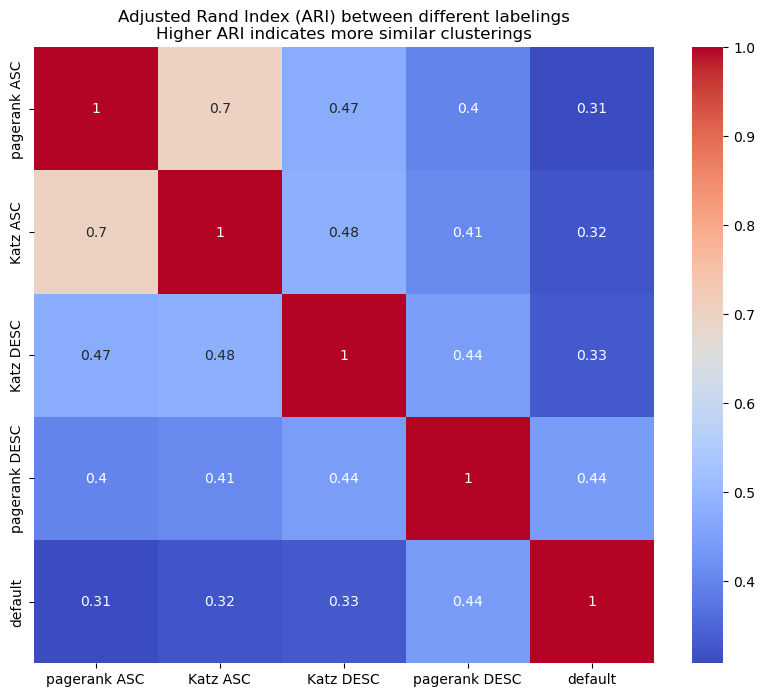

In [ ]:


results.sort(key=lambda x: x[2])
labels = [labels for _, _, _, labels in results]


# Calculate the ARI between each pair of labels
n_labels = len(labels)
ari_matrix = np.zeros((n_labels, n_labels))

for i in range(n_labels):
	for j in range(n_labels):
		ari_matrix[i, j] = adjusted_rand_score(labels[i], labels[j])

# Plot the ARI matrix
plt.figure(figsize=(10, 8))
sns.heatmap(ari_matrix, annot=True, cmap='coolwarm', xticklabels=[res[1] for res in results], yticklabels=[res[1] for res in results])
plt.title('Adjusted Rand Index (ARI) between different labelings\nHigher ARI indicates more similar clusterings')
plt.show()

## In summary

Sorting the graph will have an effect, although an small one. Apparently sorting by pagerank DESC leads to the best result and it makes sense since it would take into consideration the most important nodes first. 

The change in modularity however seems to be a small amount. The real change occurs not in the modularity but rather on where the nodes that could easily belong to one or another node goes.


When using PageRank DESC, then higher PageRank scores (more important nodes) are processed first. This means that we prioritize important nodes and care the most about central nodes in the clusters. 

When using PageRank DESC, then less important nodes are processed first. This means that communities are defined first on the "outskirts".


The amount of clusters found also varies from one method to the other. When no ordering is applied the result was higher, meaning that we might have some unnecessary clusters. PageRank DESC and Katz ASC behave similarly and create a similar amount of clusters which is lower than the one generated by their ASC counterpart.

The most similar methods are PageRank ASC and Katz ASC. Their DESC counterparts are also similar but not as much. Finally the default version (with no ordering added) is the most distinct to everyone. This means that to have consistent results it is a good idea to sort the nodes and choose what you want to prioritize, central nodes or peripherial nodes.